In [1]:
#Imports
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import time
import datetime as dt
import praw
import nltk

import seaborn as sns
import matplotlib.pyplot as plt

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

In [2]:
#allows all columns to be scrolled
pd.set_option('display.max_columns', None)

# Source:https://stackoverflow.com/questions/47022070/display-all-dataframe-columns-in-a-jupyter-python-notebook/47022213 

In [3]:
#displays all text in dataframes
pd.set_option('display.max_colwidth', None)

# https://stackoverflow.com/questions/25351968/how-to-display-full-non-truncated-dataframe-information-in-html-when-convertin

# Table of Contents

* [Read In Our Data](#Read-In-Out-Data)
* [Data Cleaning](#Data-Cleaning)
    * [Posts](#Posts)
    * [Comments](#Comments)
* [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    * [Scores](#What-is-the-score-of-each-post?)
    * [Correlations](#Is-there-a-correlation-between-upvotes-and-comments?-Other-correlations?)
    * [Comments](#Distribution-of-Comments)
    * [Flair Categories](#Exploring-Flair-Categories)
* [Model Prep](#Let's-prep-our-data-to-make-a-model)
* [Additional Exploratory Data Analysis](#Additional-Exploratory-Data-Analysis)
    * [Sentiment Analysis - Post Title & Body](#Sentiment-Analysis---Post-Title-and-Body)
    * [Sentiment Analysis - Comments](#Sentiment-Analysis---Comments)
    * [Company Comparisons](#Exploring-Company-Comparisons)


# Read In Our Data

In [4]:
#posts
alexa = pd.read_csv('./data/alexa_subreddit.csv')
google = pd.read_csv('./data/googlehome_subreddit.csv')

In [5]:
#comments
alexa_comments = pd.read_csv('./data/alexa_comments_subreddit.csv')
google_comments = pd.read_csv('./data/googlehome_comments_subreddit.csv')

In [6]:
#same dataframes in a list for easy exploration and data cleaning
dfs = [alexa, google]
comments_dfs = [alexa_comments, google_comments]

# Data Cleaning

## Posts

### Drop the `Unnamed: 0` column

In [7]:
alexa.drop(columns='Unnamed: 0', inplace=True)
google.drop(columns='Unnamed: 0', inplace=True)

### Change `created` to datetime

In [8]:
def created_to_datetime(dataframe):   
    dataframe['created'] = dataframe['created'].apply(lambda x: dt.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S')) #credit: https://www.w3resource.com/python-exercises/date-time-exercise/python-date-time-exercise-6.php
    dataframe['created'] = pd.to_datetime(dataframe['created']) 
    
    return dataframe.head(2)

In [9]:
#change all dataframes 'created' column to datetime
for df in dfs:
    created_to_datetime(df)

### Review dataframe `shape` and `min()` date to see how dateframes compare

In [10]:
for df in dfs:   
    print(f'{df["subreddit"][0]} Shape: {df.shape}')
    print(f"Earliest Date Collected:  {df['created'].min()}")
    print()

#comments
print(f'Alexa Comments Shape: {alexa_comments.shape}')
print(f'Google Home Comments Shape: {google_comments.shape}')

alexa Shape: (998, 12)
Earliest Date Collected:  2020-05-26 15:47:18

googlehome Shape: (962, 12)
Earliest Date Collected:  2020-07-27 18:17:42

Alexa Comments Shape: (4482, 5)
Google Home Comments Shape: (6233, 5)


### Posts Over Time

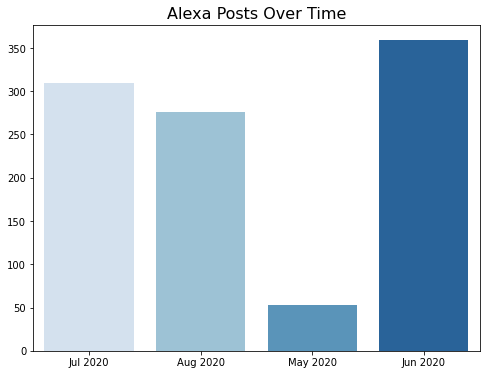

In [11]:
alexa_posts_ct = alexa['created'].dt.strftime('%b %Y').value_counts(sort=False) 

plt.figure(figsize=(8,6))
sns.barplot(alexa_posts_ct.index, alexa_posts_ct.values, palette='Blues')
plt.title('Alexa Posts Over Time', fontsize=16)
plt.savefig('./imgs/alexa_posts.jpeg',bbox_inches='tight');

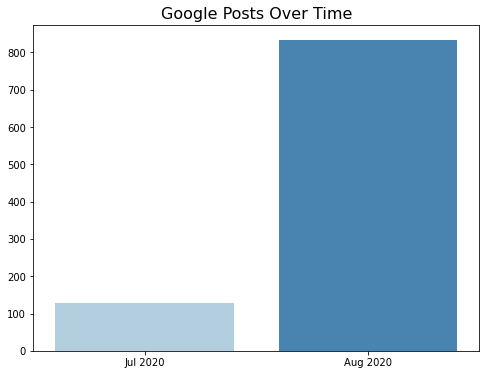

In [12]:
google_posts_ct = google['created'].dt.strftime('%b %Y').value_counts(sort=False)

plt.figure(figsize=(8,6))
sns.barplot(google_posts_ct.index, google_posts_ct.values, palette='Blues')
plt.title('Google Posts Over Time',fontsize=16)
plt.savefig('./imgs/google_posts.jpeg',bbox_inches='tight');

## Comments

### Drop the `Unnamed: 0` column

In [13]:
alexa_comments.drop(columns='Unnamed: 0', inplace=True)
google_comments.drop(columns='Unnamed: 0', inplace=True)

# Exploratory Data Analysis

### What is the score of each post?

Score is a measure of `upvotes - downvotes`

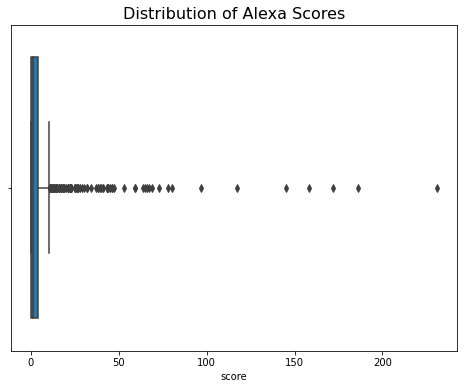

In [14]:
plt.figure(figsize=(8,6))
sns.boxplot(alexa['score'])
plt.title(f'Distribution of Alexa Scores', fontsize=16);
plt.savefig('./imgs/alexa_scores.jpeg',bbox_inches='tight');

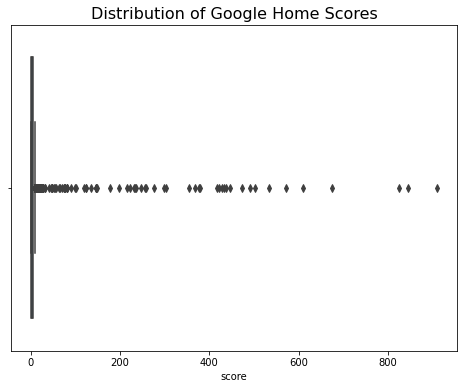

In [15]:
plt.figure(figsize=(8,6))
sns.boxplot(google['score'])
plt.title(f'Distribution of Google Home Scores',fontsize=16);
plt.savefig('./imgs/google_scores.jpeg',bbox_inches='tight');

### Posts With The Highest Scores

In [16]:
# Alexa
alexa[['title','selftext','url','flair','score']].sort_values(by='score', ascending=False).head(20)

,title,selftext,url,flair,score
189,Nice,NaN,https://i.redd.it/o9lfyi1gb8g51.jpg,NaN,231
256,I created a skill that will play “Piano Man” by Billy Joel so it will play the line “it’s 9 o’clock on a Saturday” at exactly 9:00 on a Saturday.,NaN,https://i.redd.it/lfgnpy5zgpe51.jpg,NaN,186
698,"the alexa app is crap. it's slow, laggy, fully of bugs, and just a pain in the arse to use.","title. \n\n\nthe actual devices are fine, but the app is shit.",https://www.reddit.com/r/alexa/comments/hdapdz/the_alexa_app_is_crap_its_slow_laggy_fully_of/,NaN,172
475,My kids have worked out how to set reminders on their siblings Echo from their own,NaN,https://i.redd.it/edjdlfj7soa51.jpg,NaN,158
619,Did she just troll me?,NaN,https://i.redd.it/hfidedl6si751.jpg,NaN,145
551,"My Alexa woke up to a fart, been some time since i laughed so hard",NaN,https://streamable.com/r6lm9u,NaN,117
779,Got my Alexa glasses today!,NaN,https://i.redd.it/12y9ilc4ix451.jpg,NaN,97
610,Reminders like this please.,"""Alexa, I've put my red jacket in the storage container in the spare room.""\n\nMonths later.\n\n""Alexa, Where is my red jacket?""\n\n""You'll find your red jacket in the storage container in the spare room.""\n\nMake this happen.",https://www.reddit.com/r/alexa/comments/hhvy2x/reminders_like_this_please/,NaN,80
899,I am currently working on an Alexa skill that lets users play YouTube videos via audio on Alexa devices without a screen/ plays the video on those devices with a screen. Essentially this is a skill that lets users listen to music/videos for free without a subscription!,Please post additional features you would like me to add to this skill in the replies below! Thanks!,https://www.reddit.com/r/alexa/comments/gwm3bm/i_am_currently_working_on_an_alexa_skill_that/,NaN,78
48,Anyone Else Get Really Annoyed by Alexa’s “By the way...”,"I know this might be a picky thing, but it seriously annoys me so much when Alexa does the “By the way...” thing. I think it’s mostly because I usually just want a quick answer without having to wait for Alexa to say her whole spiel about how much she can do for me as an assistant. It’s happened to me twice today: once when turning on the lights and another when I asked her for the weather. It bugs me so much and I wish there was an option to disable it.",https://www.reddit.com/r/alexa/comments/iep0ee/anyone_else_get_really_annoyed_by_alexas_by_the/,NaN,73


In [17]:
#googlehome
google[['title','selftext','url','flair','score']].sort_values(by='score', ascending=False).head(20)

,title,selftext,url,flair,score
465,I really should be more specific.,NaN,https://i.redd.it/qfxdlkw1vmg51.jpg,NaN,910
78,"Dark mode has arrived, at long last!",NaN,https://i.redd.it/qhfofco2r5j51.png,NaN,845
353,I got rick rolled by Assistant,NaN,https://i.imgur.com/faZ8yFG.png,NaN,826
705,"Google ""Nest-ing"" Camera",NaN,https://www.reddit.com/gallery/i4bucb,Tips,676
120,Cat just threw up and I was telling them to stop doing it and Google laid this on me,NaN,https://imgur.com/UZrp4fi,Other,609
139,Google WiFi finally merge into Google home app,NaN,https://i.redd.it/5rhv7zoliri51.png,News,571
249,"Notification: ""Someone is at the front door""",NaN,https://v.redd.it/efa7h4k85xh51,NaN,533
908,"Today, my kid accidentally dropped and broke glassware and then I received this message. I was happy it recognized. Should I be concerned?? I read somewhere that Google Assistant would not process until it's prompted with "" Ok Google""",NaN,https://i.redd.it/6rty0juh6wd51.png,NaN,503
822,My partner was drunk and home alone last night and...,NaN,https://i.redd.it/t8we0uvhzee51.jpg,NaN,490
861,groan...,NaN,https://i.redd.it/ve8k00z8r6e51.png,NaN,474


#### What have we learned? Funny images and videos get the most upvotes, feature requests, and collective user frustrations also get upvoted.

### Is there a correlation between upvotes and comments? Other correlations?

### Alexa

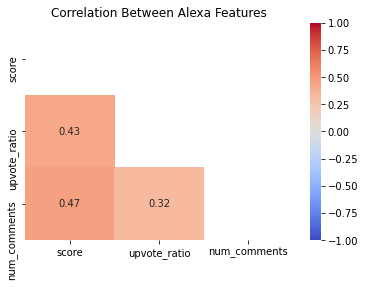

In [18]:
corr = alexa[['score','upvote_ratio','num_comments']].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,vmin=-1, vmax=1, annot=True,cmap='coolwarm', mask=mask)
plt.title('Correlation Between Alexa Features');

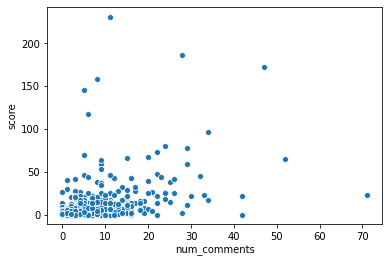

In [19]:
#Alexa
sns.scatterplot(alexa['num_comments'], alexa['score']);

### Google

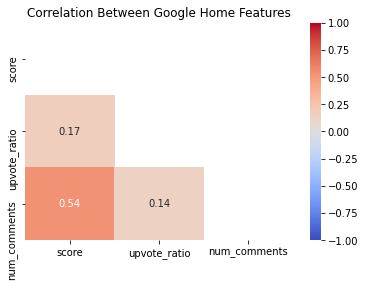

In [20]:
corr = google[['score','upvote_ratio','num_comments']].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,vmin=-1, vmax=1, annot=True,cmap='coolwarm', mask=mask)
plt.title('Correlation Between Google Home Features');

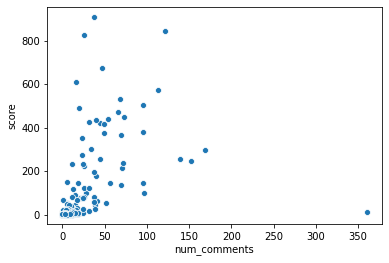

In [21]:
#Google
sns.scatterplot(google['num_comments'], google['score']);

## Distribution of Comments

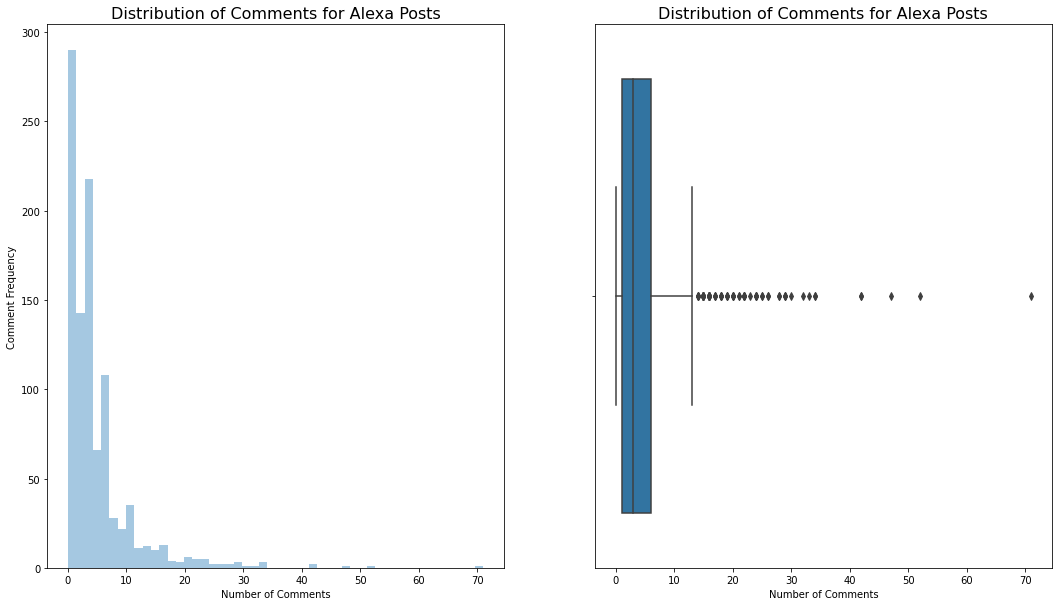

In [22]:
fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(18,10))
sns.distplot(alexa['num_comments'], ax=ax1,kde=False)
ax1.set_xlabel('Number of Comments')
ax1.set_ylabel('Comment Frequency')
ax1.set_title('Distribution of Comments for Alexa Posts', fontsize=16);

sns.boxplot(alexa['num_comments'], ax=ax2)
ax2.set_xlabel('Number of Comments')
ax2.set_title('Distribution of Comments for Alexa Posts',fontsize=16);
plt.savefig('./imgs/alexa_comments.jpeg',bbox_inches='tight');

#saving a subplot - https://stackoverflow.com/questions/4325733/save-a-subplot-in-matplotlib 
extent = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('./imgs/alexa_comments_box.jpeg', bbox_inches=extent.expanded(1.1, 1.2))

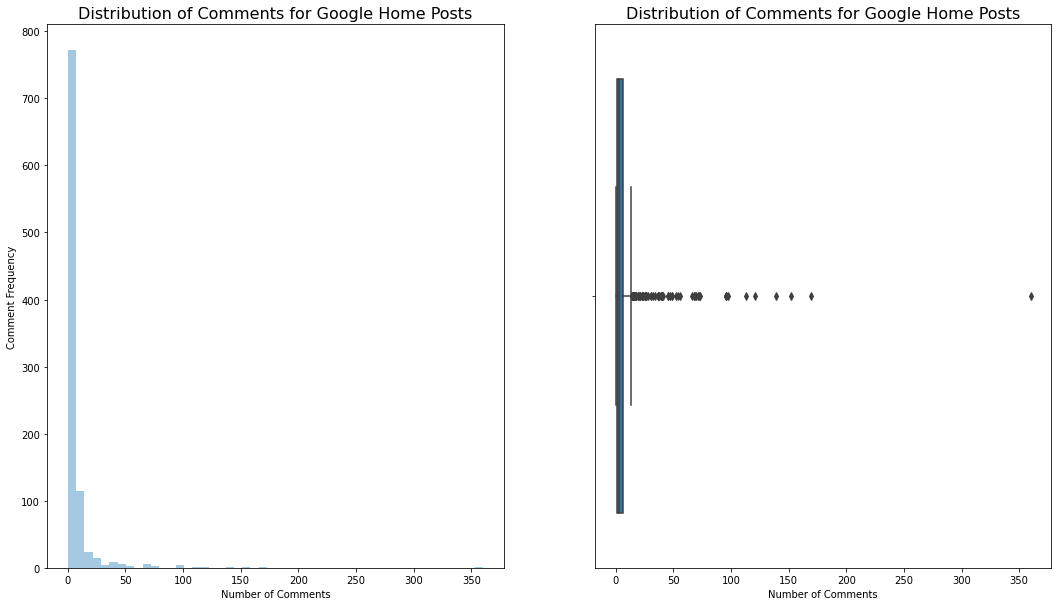

In [23]:
fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(18,10))
sns.distplot(google['num_comments'], ax=ax1,kde=False)
ax1.set_xlabel('Number of Comments')
ax1.set_ylabel('Comment Frequency')
ax1.set_title('Distribution of Comments for Google Home Posts',fontsize=16);

sns.boxplot(google['num_comments'], ax=ax2)
ax2.set_xlabel('Number of Comments')
ax2.set_title('Distribution of Comments for Google Home Posts',fontsize=16);
plt.savefig('./imgs/google_comments.jpeg',bbox_inches='tight');

#saving a subplot - https://stackoverflow.com/questions/4325733/save-a-subplot-in-matplotlib 
extent = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('./imgs/google_comments_box.jpeg', bbox_inches=extent.expanded(1.1, 1.2))

#### What have we learned? Since the Google Home subreddit has a higher member counts, number of comments for each post are also higher.

## Most Commented Posts

### Alexa

In [24]:
# Alexa
alexa[['title','selftext','url','flair','score','num_comments']].sort_values(by='num_comments', ascending=False).head(10)

,title,selftext,url,flair,score,num_comments
738,Alexa has my smart light colors all wrong?,"So i just got my echo dot, and i connected it to my Airlux smart lights. However, when I say ""Alexa, set lights to blue"", she changes them to pink. Every color seems to be the wrong color except for white. I use the Smart Life app for the lights, but I don't think it's that, because when I use Google assistant it changes the colors just fine. Anybody know what the issue is?\n\nEDIT: Okay now the same issue is happening with Google assistant. Before I set up my Alexa, Google assistant changed the colors just fine.\n\nEDIT 2: Alright apparently this is a big issue that like everybody is experiencing that just started last night, so I guess I just had unfortunate timing. From what I hear this seems to be an update bug or glitch and Amazon devs have said they are working on it.\n\nEDIT 3: Okay so now it appears to be fixed, mine started working fine later last night, and it seems many other have had it fixed. I guess it was just an update glitch or something. Thanks for all the replies tho!",https://www.reddit.com/r/alexa/comments/hbl9iq/alexa_has_my_smart_light_colors_all_wrong/,NaN,23,71
575,Alexa getting less intelligent all the time.,Alexa cancel my 8:10 am reminder\n\nyou have nothing on your calendar for 8:10 am\n\nAlexa what are my reminders?\n\nyou have a reminder at 8:10 am\n\nAlexa cancel my 8:10 am reminder\n\nyou have nothing on your calendar for 8:10 am\n\nAlexa what's on my calendar today\n\nyou have a reminder at 8:10 am......\n\n:(,https://www.reddit.com/r/alexa/comments/hjxdgc/alexa_getting_less_intelligent_all_the_time/,NaN,65,52
698,"the alexa app is crap. it's slow, laggy, fully of bugs, and just a pain in the arse to use.","title. \n\n\nthe actual devices are fine, but the app is shit.",https://www.reddit.com/r/alexa/comments/hdapdz/the_alexa_app_is_crap_its_slow_laggy_fully_of/,NaN,172,47
433,Your Amazon Alexa and Echo Show Are Sneaking Around Your Network Trying To Bypass Your Security Settings And Send Your Personal Information Out Without You Knowing About It,NaN,https://i.redd.it/d9kl0ce87ib51.png,NaN,0,42
358,Can i get her to stop announcing that she's now connected to bluetooth?,NaN,https://www.reddit.com/r/alexa/comments/hxm6gb/can_i_get_her_to_stop_announcing_that_shes_now/,NaN,22,42
779,Got my Alexa glasses today!,NaN,https://i.redd.it/12y9ilc4ix451.jpg,NaN,97,34
591,Favorite Automation or Routine?,Looking to hoard all your good ideas for myself! LOL. \n\nWhat is your:\n- Favorite routine or automation you’ve setup?\n- Most used?\n- The one you can’t wait to show people?\n- The one that’s not very cool but would be super frustrating if it stopped working?\n- Got anything for pets? (Dogs and aquariums here.)\n\nLet me know if I missed anything! I love hearing about all the cool things you guys setup!,https://www.reddit.com/r/alexa/comments/him73r/favorite_automation_or_routine/,NaN,17,34
764,Amazon Basics smart microwave - my first impressions,"I am happy with this device so far, and here's why:\n\n1. This $60 device replaces a 16-year-old microwave with a defective button pad. \n1. I have already used the water preset to make passable tea\n1. The setup was automatic. I was still reading the directions when it connected.\n1. The microwave *looks* like it belongs in my apartment. \n1. I feel like a total boss just looking at it - ""Alex, play the space 1999 tv theme""\n1. I am no longer one of those luddite savages pressing buttons to make the magic box work\n\nAs far as complaints, go:\n\n1. There's a preset for coffee (*Bleagh!*), but not tea. Savages. \n1. the magical list of presets is *very* short, but Amazon really played it up as something special. I'm hoping that they add a lot more. \n\nOther than that, I have had this thing for three hours, and I'm pretty happy. But then, I would be happy with any new microwave with working features. My old microwave is a disgusting mess with a broken keypad, so it 

#### Posts are about frustrations with the product, new product announcements, and favorite functionality.

### Google

In [25]:
# Google
google[['title','selftext','url','flair','score','num_comments']].sort_values(by='num_comments', ascending=False).head(10)

,title,selftext,url,flair,score,num_comments
681,Monthly Rants and Complaints Thread - August 2020,"Please tell us about your Google problems. Post all your rants, complaints, and frustrations here! Vent it all out!",https://www.reddit.com/r/googlehome/comments/i4xxe2/monthly_rants_and_complaints_thread_august_2020/,NaN,12,360
735,Google Play Music will be discontinued starting September. New Zealand and South Africa you go first.,NaN,https://www.androidpolice.com/2020/08/04/google-play-music-will-be-discontinued-starting-september/,News,298,169
927,"PSA: Per Google, playlists for YouTube Music is not yet supported. I sure hope this happens before they sunset GPM, which is supposed to happen sometime this year.",I hope that the Engineering teams from both GPM and YTM understand that this is a degradation of feature functionality.,https://www.reddit.com/r/googlehome/comments/i00j3d/psa_per_google_playlists_for_youtube_music_is_not/,Bug,247,152
269,Can anybody tell me what is going on in this video? I have several clips of this taken last night (8/18) it looks like snow but it's summer lol,NaN,https://v.redd.it/cxbeisjqvth51,Help,257,139
78,"Dark mode has arrived, at long last!",NaN,https://i.redd.it/qhfofco2r5j51.png,NaN,845,121
139,Google WiFi finally merge into Google home app,NaN,https://i.redd.it/5rhv7zoliri51.png,News,571,113
180,Casual Ad-Free Music on GH Devices in The Future,"With the upcoming demise of Google Play music, are we going to be completely unable to listen to ad-free music on our Google and Nest devices?\n\nI just tried out Youtube Music and it started playing annoying ads to sign up to Youtube Music Premium after EVERY SONG. What absolute garbage.\n\nHow are you guys planning on listening to music in the future? Is there something I'm missing as an option?",https://www.reddit.com/r/googlehome/comments/ie4w4m/casual_adfree_music_on_gh_devices_in_the_future/,NaN,99,97
607,After having a Google Home for a little over a year I just realized this,"When setting an alarm I'd say hey Google, set alarm for 9:00, Wait it for to register, then repeat the same process for 9:30. However I just realize that I can do them all in one shot ""hey Google set alarms for 9:00 and 9:30... FML",https://www.reddit.com/r/googlehome/comments/i6exc3/after_having_a_google_home_for_a_little_over_a/,Other,380,96
908,"Today, my kid accidentally dropped and broke glassware and then I received this message. I was happy it recognized. Should I be concerned?? I read somewhere that Google Assistant would not process until it's prompted with "" Ok Google""",NaN,https://i.redd.it/6rty0juh6wd51.png,NaN,503,96
774,Google Makes Big Bet On ADT,NaN,https://www.thetechie.de/2020/08/google-makes-big-bet-on-adt.html,NaN,145,96


#### The Google Home community has created a monthly rants thread, this can reveal major frustrations with the product. Other posts include product updates and favorite functionality.

## Exploring Flair Categories

These are sub-categories within the subreddit that help group post content.

#### Alexa

In [26]:
#alexa has no categories
alexa[['flair']].value_counts()

Series([], dtype: int64)

#### Since no flair categories are available, let's search for posts with keywords that may indicate problems or bugs that need help

In [27]:
#search posts with the words that may indicate problems or bugs that need help
alexa_bugs = alexa[alexa['title'].str.contains('please help|bug|error|problem|stop working', regex=True) | alexa['selftext'].str.contains('please help|bug|error|problem', regex=True)]

In [28]:
alexa_bugs.shape

(95, 12)

In [29]:
alexa_bugs.head(2)

,subreddit,id,comment_link_id,title,selftext,score,upvote_ratio,num_comments,flair,url,author,created
3,alexa,ih4pme,t3_ih4pme,Music / Podcasts not consistent.,"If im listening to something (such as a podcast) and I pause, when i come back after a few hours and ask to resume she starts the episode / track fro the beginning instead of where i was.\n\nAnyone else has this problem and has a solution?\n\nThanks",6,0.88,0,NaN,https://www.reddit.com/r/alexa/comments/ih4pme/music_podcasts_not_consistent/,JustWhy69,2020-08-26 11:44:35
12,alexa,igg5o3,t3_igg5o3,"Alexa ""doesn't know how to set all lights to that setting""","Hey everyone,\n\nI have Alexa in my bedroom, bathroom, and living room. I have multiple ceiling and lamp light fixtures connected to Alexa. For more than a year I've been able to say commands like ""Alexa, brighten all the lights of 100%"" or ""Alexa, turn off all the lights"" or ""Alexa, brighten living room lights to 50%""\n\nBut now something must've happened and when asked to brighten all the lights to 100% Alexa responds by saying ""I don't know how to set all lights to that setting""\n\nAny advice on how to fix this? I suspect I need to rename some of my room arrangements, but I'm not sure what exactly is the problem",0,0.40,2,NaN,https://www.reddit.com/r/alexa/comments/igg5o3/alexa_doesnt_know_how_to_set_all_lights_to_that/,needakeepatit,2020-08-25 09:59:45


#### Search for posts with keywords that may indicate feature requests

In [30]:
alexa_features = alexa[alexa['title'].str.contains('feature|request|feature request', regex=True) | alexa['selftext'].str.contains('feature|request|feature request', regex=True)]
alexa_features.shape

(67, 12)

In [31]:
alexa_features.head(2)

,subreddit,id,comment_link_id,title,selftext,score,upvote_ratio,num_comments,flair,url,author,created
2,alexa,ih8eq0,t3_ih8eq0,what alexa features could be in use for this ghost prank?,"please note i am not a believer in ghosts and if i was i dont think theyd be able to communicate by alexa. thats why im pretty certain theres some trickery here.\n\nbasically, i believe someone i know is being pranked through an alexa to think her dorm is haunted. their alexa is connected to one of the roommates, but as far as we know, none of the others (a total of four.) \n\nthe alexa was acting odd already-playing music without any commands or apparent stimulation, randomly saying stuff. then, after playing a ghost app twice and discerning the ghost name as ""robert,"" on the same day the alexa randomly said M (owner of alexa) says: Robert\n\nafter that they held a like... q&a with it where they wrote questions on a paper, crumpled it up, and the alexa answered in coherent one word responses in order of what they wrote. as far as i know, these did not include the ""M says..."" preface; it was just saying the words. no notification sound either. im wondering if any of you know what feature of the alexa could be used for this prank to comfort my friend and explain why shes likely being pranked by M and not actually experiencing a ghost. i dont think itd be anything too complex feature wise bc i did find a video where you can code it to say anything but i really dont think any of them would be able to do that, and its likely phone controlled. any ideas?",1,0.67,1,NaN,https://www.reddit.com/r/alexa/comments/ih8eq0/what_alexa_features_could_be_in_use_for_this/,tinyheartbag,2020-08-26 14:56:25
5,alexa,ih1s0i,t3_ih1s0i,Stop Alexa from asking to learn my voice,Is there anyway to permanently stop Alexa from asking to learn my voice? I have searched and can’t find anything about my this request. Thanks for any help.,0,0.50,9,NaN,https://www.reddit.com/r/alexa/comments/ih1s0i/stop_alexa_from_asking_to_learn_my_voice/,teaky,2020-08-26 09:13:06


#### Google

In [32]:
google[['flair']].value_counts()

flair              
Help                   253
Bug                     54
Other                   28
Commands | How To's     18
Features WishList       17
Tips                    10
News                    10
NSFW - Language          5
GH Trigger Warning       4
Hacks                    2
Product Review           1
dtype: int64

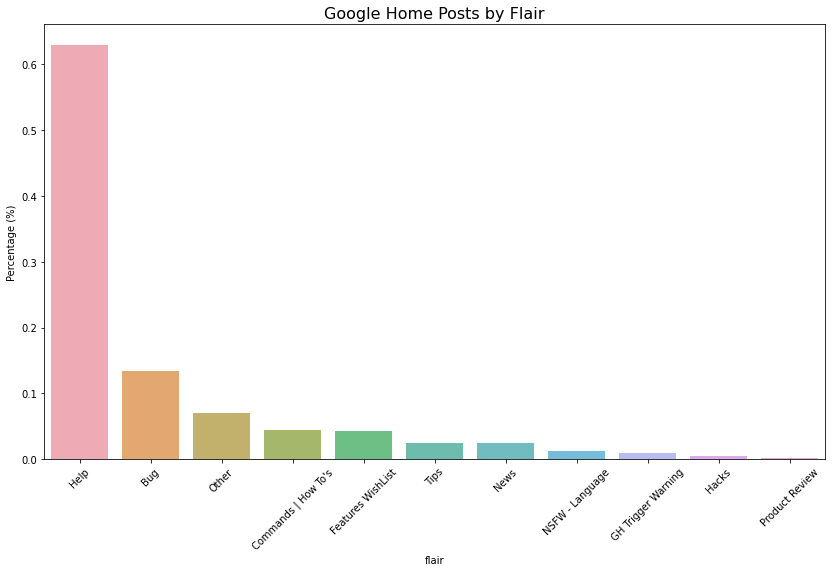

In [33]:
#save as dataframe for easy plotting
google_flair_df = google[['flair']].value_counts(normalize=True).reset_index()
google_flair_df.columns = ['flair','Percentage (%)']

plt.figure(figsize=(14,8))
sns.barplot(google_flair_df['flair'], 
            google_flair_df['Percentage (%)'], 
            alpha=0.8);
plt.title('Google Home Posts by Flair', fontsize=16)
plt.xticks(rotation=45);
plt.savefig('./imgs/google_flair.jpeg',bbox_inches='tight');

### We can infer here that most posts are related to help/bug questions. 

# Let's prep our data to make a model

### Combine dataframes

In [34]:
#Use concat
alexa_google = pd.concat([google, alexa])
alexa_google.head(2)

,subreddit,id,comment_link_id,title,selftext,score,upvote_ratio,num_comments,flair,url,author,created
0,googlehome,ihb3t9,t3_ihb3t9,Double up,"Anyone know how to remove double light/sensor indicator on my Home app? I have a Fibaro motion sensor in my bedroom, but its listed twice. Thanks.",1,1.0,0,Help,https://www.reddit.com/r/googlehome/comments/ihb3t9/double_up/,stigjohan1974,2020-08-26 17:37:50
1,googlehome,ihatuu,t3_ihatuu,"Is my mini done for? Was listening to a podcast and the lights started flashing, unresponsive to commands. Them it started beeping too",NaN,2,1.0,1,NaN,http://imgur.com/a/jAgmwfo,polkadotfuzz,2020-08-26 17:19:54


### Binarize subreddit column

### `googlehome = 0`, `alexa = 1`

In [35]:
#Google = 0, Alexa = 1
alexa_google['class'] = alexa_google['subreddit'].map({"googlehome":0,
                                                       "alexa":1})
alexa_google.head(2)

,subreddit,id,comment_link_id,title,selftext,score,upvote_ratio,num_comments,flair,url,author,created,class
0,googlehome,ihb3t9,t3_ihb3t9,Double up,"Anyone know how to remove double light/sensor indicator on my Home app? I have a Fibaro motion sensor in my bedroom, but its listed twice. Thanks.",1,1.0,0,Help,https://www.reddit.com/r/googlehome/comments/ihb3t9/double_up/,stigjohan1974,2020-08-26 17:37:50,0
1,googlehome,ihatuu,t3_ihatuu,"Is my mini done for? Was listening to a podcast and the lights started flashing, unresponsive to commands. Them it started beeping too",NaN,2,1.0,1,NaN,http://imgur.com/a/jAgmwfo,polkadotfuzz,2020-08-26 17:19:54,0


### Check for null values

In [36]:
alexa_google.isnull().sum()

subreddit             0
id                    0
comment_link_id       0
title                 0
selftext            338
score                 0
upvote_ratio          0
num_comments          0
flair              1558
url                   0
author                8
created               0
class                 0
dtype: int64

### Combine `title` and `selftext` columns

##### We are doing this to also solve the problem of null values in selftext.

In [37]:
#First let's add an empty string to the null values in selftext
alexa_google['selftext'].fillna('',inplace=True)

In [38]:
# Combine the title and selftext columns
alexa_google['text'] = alexa_google['title'] + ' ' + alexa_google['selftext']
alexa_google.head(2)

,subreddit,id,comment_link_id,title,selftext,score,upvote_ratio,num_comments,flair,url,author,created,class,text
0,googlehome,ihb3t9,t3_ihb3t9,Double up,"Anyone know how to remove double light/sensor indicator on my Home app? I have a Fibaro motion sensor in my bedroom, but its listed twice. Thanks.",1,1.0,0,Help,https://www.reddit.com/r/googlehome/comments/ihb3t9/double_up/,stigjohan1974,2020-08-26 17:37:50,0,"Double up Anyone know how to remove double light/sensor indicator on my Home app? I have a Fibaro motion sensor in my bedroom, but its listed twice. Thanks."
1,googlehome,ihatuu,t3_ihatuu,"Is my mini done for? Was listening to a podcast and the lights started flashing, unresponsive to commands. Them it started beeping too",,2,1.0,1,NaN,http://imgur.com/a/jAgmwfo,polkadotfuzz,2020-08-26 17:19:54,0,"Is my mini done for? Was listening to a podcast and the lights started flashing, unresponsive to commands. Them it started beeping too"


In [39]:
#check our work
alexa_google.isnull().sum()

subreddit             0
id                    0
comment_link_id       0
title                 0
selftext              0
score                 0
upvote_ratio          0
num_comments          0
flair              1558
url                   0
author                8
created               0
class                 0
text                  0
dtype: int64

## Save our data for later use

In [40]:
alexa_google.to_csv('./data/alexa_google_cleaned.csv',index=False)

# Additional Exploratory Data Analysis

### Correlations

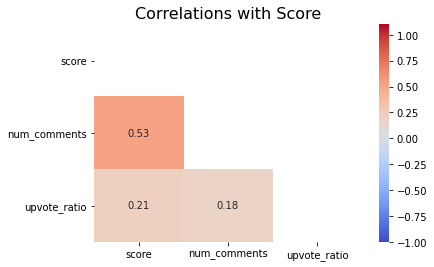

In [41]:
corr = alexa_google[['score','num_comments','upvote_ratio']].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,vmin=-1, vmax=1.1, annot=True,cmap='coolwarm', mask=mask)
plt.title('Correlations with Score',fontsize=16);
plt.savefig('./imgs/correlations.jpeg',bbox_inches='tight');

## Sentiment Analysis - Post Title and Body

In [42]:
vader = SentimentIntensityAnalyzer()
results = []

for text in alexa_google['text']:
    pol_score = vader.polarity_scores(text)  #stores analysis in a list with dictionaries
    pol_score['text'] = text                 #adds to the pol_score dictionary the text
    results.append(pol_score)                #appends to the results list

print(results[:3])

#Adapted from https://www.learndatasci.com/tutorials/sentiment-analysis-reddit-headlines-pythons-nltk/

[{'neg': 0.0, 'neu': 0.867, 'pos': 0.133, 'compound': 0.5927, 'text': 'Double up Anyone know how to remove double light/sensor indicator on my Home app? I have a Fibaro motion sensor in my bedroom, but its listed twice. Thanks.'}, {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0, 'text': 'Is my mini done for? Was listening to a podcast and the lights started flashing, unresponsive to commands. Them it started beeping too '}, {'neg': 0.012, 'neu': 0.927, 'pos': 0.061, 'compound': 0.8406, 'text': "I use a Google Home Max as my TV's soundbar... any way to control volume without voice/phone? I'm looking for the best way to adjust the volume on my Google Home Max that's connected to my TV. It is connected via a 3.5mm audio cable. \n\nI also have an Nvidia Shield as my main TV box. I can use the Google assistant in the Shield to control the volume, but through voice commands and not through the remote's volume control. I've tried using HDMI-CEC to control it, but that ends up controlling

In [43]:
df = pd.DataFrame.from_records(results)
df.head()

,neg,neu,pos,compound,text
0,0.000,0.867,0.133,0.5927,"Double up Anyone know how to remove double light/sensor indicator on my Home app? I have a Fibaro motion sensor in my bedroom, but its listed twice. Thanks."
1,0.000,1.000,0.000,0.0000,"Is my mini done for? Was listening to a podcast and the lights started flashing, unresponsive to commands. Them it started beeping too"
2,0.012,0.927,0.061,0.8406,"I use a Google Home Max as my TV's soundbar... any way to control volume without voice/phone? I'm looking for the best way to adjust the volume on my Google Home Max that's connected to my TV. It is connected via a 3.5mm audio cable. \n\nI also have an Nvidia Shield as my main TV box. I can use the Google assistant in the Shield to control the volume, but through voice commands and not through the remote's volume control. I've tried using HDMI-CEC to control it, but that ends up controlling the TV volume. \n\nI also have an Nintendo Switch on the TV, so I don't want to resort to use the Shield's built in volume.\n\n&#x200B;\n\nAnyone else using their Google Home max this way? What are the best ways you've been able to use it as soundbar and with controlling volume."
3,0.044,0.901,0.055,0.1431,"Why can't I tell my Google Home to ""STOP"" anymore? If it was in the middle of giving me way more information than I needed, I used to say ""hey Google, stop"" and it would quit talking. I can't anymore. It doesn't hear me and it keeps talking. Can I fix this?"
4,0.000,0.847,0.153,0.4404,Is it safe to delete Google Wifi app? now that Wifi is part of the Home app.


In [44]:
sentiment = pd.merge(left=df, right=alexa_google, how='left', right_on='text', left_on='text')
sentiment.head(2)

,neg,neu,pos,compound,text,subreddit,id,comment_link_id,title,selftext,score,upvote_ratio,num_comments,flair,url,author,created,class
0,0.0,0.867,0.133,0.5927,"Double up Anyone know how to remove double light/sensor indicator on my Home app? I have a Fibaro motion sensor in my bedroom, but its listed twice. Thanks.",googlehome,ihb3t9,t3_ihb3t9,Double up,"Anyone know how to remove double light/sensor indicator on my Home app? I have a Fibaro motion sensor in my bedroom, but its listed twice. Thanks.",1,1.0,0,Help,https://www.reddit.com/r/googlehome/comments/ihb3t9/double_up/,stigjohan1974,2020-08-26 17:37:50,0
1,0.0,1.000,0.000,0.0000,"Is my mini done for? Was listening to a podcast and the lights started flashing, unresponsive to commands. Them it started beeping too",googlehome,ihatuu,t3_ihatuu,"Is my mini done for? Was listening to a podcast and the lights started flashing, unresponsive to commands. Them it started beeping too",,2,1.0,1,NaN,http://imgur.com/a/jAgmwfo,polkadotfuzz,2020-08-26 17:19:54,0


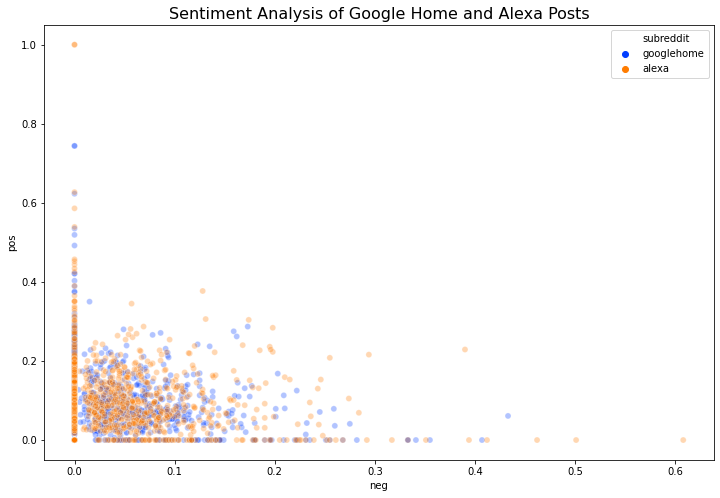

In [45]:
plt.figure(figsize=(12,8))
sns.scatterplot('neg','pos', data=sentiment, hue='subreddit',palette='bright', alpha=0.3)
plt.title('Sentiment Analysis of Google Home and Alexa Posts',fontsize=16);
plt.savefig('./imgs/sentiment_text_scatter.jpeg',bbox_inches='tight');

In [46]:
sentiment[sentiment['subreddit'] == 'googlehome'][['neg','neu','pos']].mean()

neg    0.045707
neu    0.867115
pos    0.087167
dtype: float64

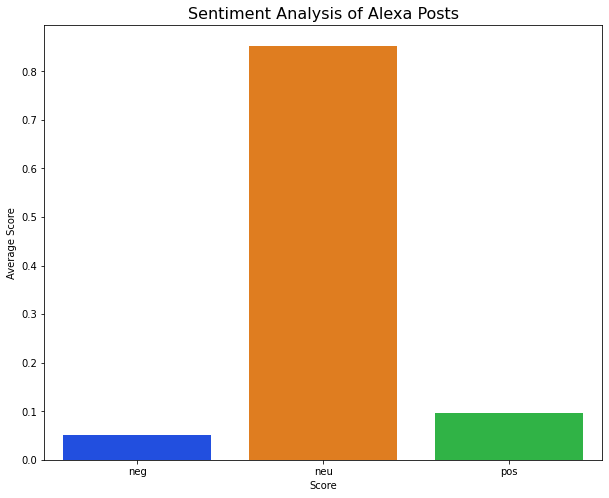

In [47]:
alexa_post_sent = sentiment[sentiment['subreddit'] == 'alexa'][['neg','neu','pos']].mean().reset_index()
alexa_post_sent.columns = ['Sentiment','Average Score']

plt.figure(figsize=(10,8))
sns.barplot(alexa_post_sent['Sentiment'],alexa_post_sent['Average Score'], palette='bright')
plt.title('Sentiment Analysis of Alexa Posts',fontsize=16);
plt.xlabel('Score')
plt.savefig('./imgs/alexa_sentiment_text.jpeg',bbox_inches='tight');

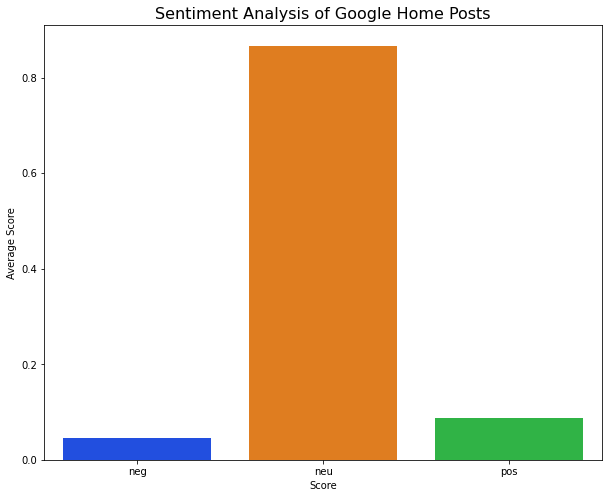

In [48]:
google_post_sent = sentiment[sentiment['subreddit'] == 'googlehome'][['neg','neu','pos']].mean().reset_index()
google_post_sent.columns = ['Sentiment','Average Score']

plt.figure(figsize=(10,8))
sns.barplot(google_post_sent['Sentiment'],google_post_sent['Average Score'],palette='bright' )
plt.title('Sentiment Analysis of Google Home Posts',fontsize=16);
plt.xlabel('Score')
plt.savefig('./imgs/google_sentiment_text.jpeg',bbox_inches='tight');

### Investigate the compound score

[The Compound score is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1 (most extreme negative) and +1 (most extreme positive)](https://medium.com/analytics-vidhya/simplifying-social-media-sentiment-analysis-using-vader-in-python-f9e6ec6fc52f)

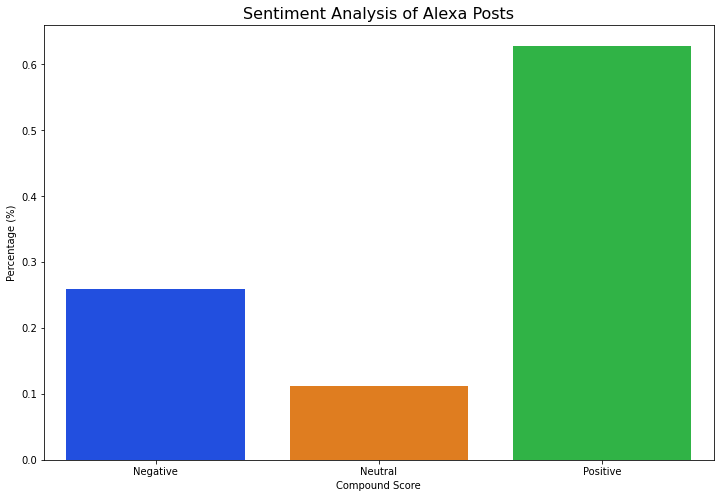

In [49]:
#calculate positve, negative, or neutral counts based on compound score
alexa_neg = sentiment[(sentiment['compound'] < -0.05) & (sentiment['subreddit'] == 'alexa')]['id'].count()
alexa_neu = sentiment[(sentiment['compound'] >= -0.05) & (sentiment['compound'] <= 0.05) &(sentiment['subreddit'] == 'alexa')]['id'].count()
alexa_pos = sentiment[(sentiment['compound'] > 0.05) &(sentiment['subreddit'] == 'alexa')]['id'].count()
alexa_total = sentiment[sentiment['subreddit'] == 'alexa']['id'].count()



plt.figure(figsize=(12,8))
sns.barplot(['Negative','Neutral','Positive'],[(alexa_neg / alexa_total),(alexa_neu / alexa_total),(alexa_pos / alexa_total)], palette='bright')
plt.title('Sentiment Analysis of Alexa Posts',fontsize=16);
plt.xlabel('Compound Score')
plt.ylabel('Percentage (%)')
plt.savefig('./imgs/alexa_sentiment_compound.jpeg',bbox_inches='tight');

In [50]:
print(f'Percent Negative: {alexa_neg / alexa_total}')
print(f'Percent Neutral: {alexa_neu / alexa_total}')
print(f'Percent Positive: {alexa_pos / alexa_total}')

Percent Negative: 0.25925925925925924
Percent Neutral: 0.11211211211211211
Percent Positive: 0.6286286286286287


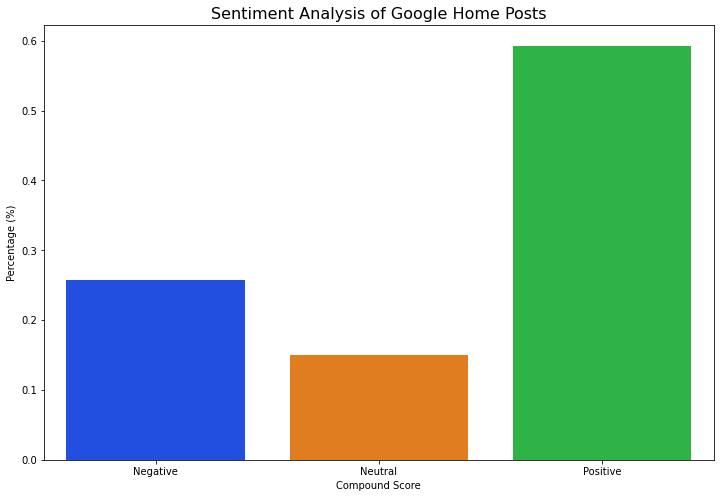

In [51]:
#calculate positve, negative, or neutral counts based on compound score
google_neg = sentiment[(sentiment['compound'] < -0.05) & (sentiment['subreddit'] == 'googlehome')]['id'].count()
google_neu = sentiment[(sentiment['compound'] >= -0.05) & (sentiment['compound'] <= 0.05) &(sentiment['subreddit'] == 'googlehome')]['id'].count()
google_pos = sentiment[(sentiment['compound'] > 0.05) &(sentiment['subreddit'] == 'googlehome')]['id'].count()
google_total = sentiment[sentiment['subreddit'] == 'googlehome']['id'].count()

plt.figure(figsize=(12,8))
sns.barplot(['Negative','Neutral','Positive'],[(google_neg / google_total),(google_neu / google_total),(google_pos / google_total)], palette='bright')
plt.title('Sentiment Analysis of Google Home Posts',fontsize=16);
plt.xlabel('Compound Score')
plt.ylabel('Percentage (%)')
plt.savefig('./imgs/google_sentiment_compound.jpeg',bbox_inches='tight');

In [52]:
print(f'Percent Negative: {google_neg / google_total}')
print(f'Percent Neutral: {google_neu / google_total}')
print(f'Percent Positive: {google_pos / google_total}')

Percent Negative: 0.25752855659397716
Percent Neutral: 0.14953271028037382
Percent Positive: 0.592938733125649


## Sentiment Analysis - Comments

### Concat Comments Dataframes

In [53]:
alexa_google_comments = pd.concat([alexa_comments, google_comments])
alexa_google_comments.head(2)

,comment_id,comment_parent_id,comment_body,comment_link_id
0,g2yxgmd,t3_iha4gi,Cool! I made one to remind me to drink water every half an hour. 😎,t3_iha4gi
1,g2ywxv5,t3_iha4gi,i love this!,t3_iha4gi


### Merge with Posts DataFrame

In [54]:
alexa_google_comments_merge = pd.merge(left=alexa_google_comments, right=alexa_google, how='left',left_on='comment_link_id', right_on='comment_link_id')
alexa_google_comments_merge.head(2)

,comment_id,comment_parent_id,comment_body,comment_link_id,subreddit,id,title,selftext,score,upvote_ratio,num_comments,flair,url,author,created,class,text
0,g2yxgmd,t3_iha4gi,Cool! I made one to remind me to drink water every half an hour. 😎,t3_iha4gi,alexa,iha4gi,"I made a routine where Alexa puts me in a good mood with music, good news, jokes, compliments... then tells my lazy ass to clean the house.",,6,1.0,2,NaN,https://www.reddit.com/gallery/iha4gi,Tyler-Savage,2020-08-26 16:36:08,1,"I made a routine where Alexa puts me in a good mood with music, good news, jokes, compliments... then tells my lazy ass to clean the house."
1,g2ywxv5,t3_iha4gi,i love this!,t3_iha4gi,alexa,iha4gi,"I made a routine where Alexa puts me in a good mood with music, good news, jokes, compliments... then tells my lazy ass to clean the house.",,6,1.0,2,NaN,https://www.reddit.com/gallery/iha4gi,Tyler-Savage,2020-08-26 16:36:08,1,"I made a routine where Alexa puts me in a good mood with music, good news, jokes, compliments... then tells my lazy ass to clean the house."


In [55]:
#Let's see the difference in comment counts
alexa_google_comments_merge.groupby('subreddit')[['comment_id']].count()

,comment_id
subreddit,
alexa,4482
googlehome,6233


In [56]:
vader_com = SentimentIntensityAnalyzer()
results_com = []

for comment in alexa_google_comments_merge['comment_body']:
    pol_score_com = vader_com.polarity_scores(comment)  #stores analysis in a list with dictionaries
    pol_score_com['comment_body'] = comment                 #adds to the pol_score dictionary the text
    results_com.append(pol_score_com)                #appends to the results list

#Adapted from https://www.learndatasci.com/tutorials/sentiment-analysis-reddit-headlines-pythons-nltk/

In [57]:
df_com = pd.DataFrame.from_records(results_com)
df_com.head(2)

,neg,neu,pos,compound,comment_body
0,0.0,0.822,0.178,0.3802,Cool! I made one to remind me to drink water every half an hour. 😎
1,0.0,0.182,0.818,0.6696,i love this!


In [58]:
sentiment_com = pd.merge(left=df_com, right=alexa_google_comments_merge, how='left',right_on='comment_body', left_on='comment_body')
sentiment_com.head(1)

,neg,neu,pos,compound,comment_body,comment_id,comment_parent_id,comment_link_id,subreddit,id,title,selftext,score,upvote_ratio,num_comments,flair,url,author,created,class,text
0,0.0,0.822,0.178,0.3802,Cool! I made one to remind me to drink water every half an hour. 😎,g2yxgmd,t3_iha4gi,t3_iha4gi,alexa,iha4gi,"I made a routine where Alexa puts me in a good mood with music, good news, jokes, compliments... then tells my lazy ass to clean the house.",,6,1.0,2,NaN,https://www.reddit.com/gallery/iha4gi,Tyler-Savage,2020-08-26 16:36:08,1,"I made a routine where Alexa puts me in a good mood with music, good news, jokes, compliments... then tells my lazy ass to clean the house."


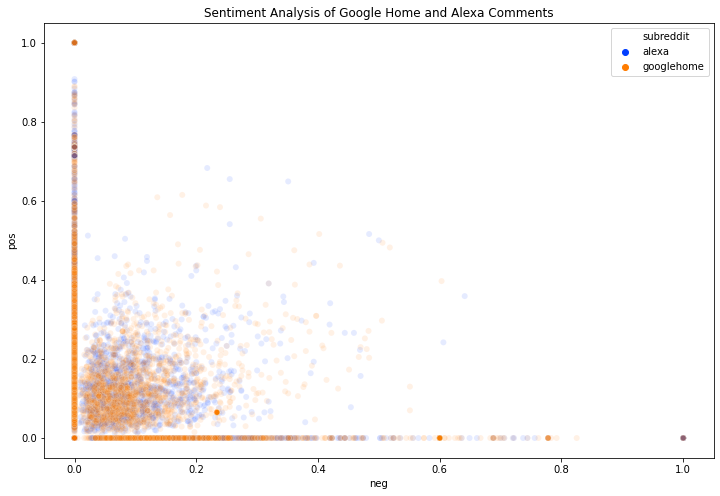

In [59]:
plt.figure(figsize=(12,8))
sns.scatterplot('neg','pos', data=sentiment_com, hue='subreddit',palette='bright', alpha=0.1)
plt.title('Sentiment Analysis of Google Home and Alexa Comments');

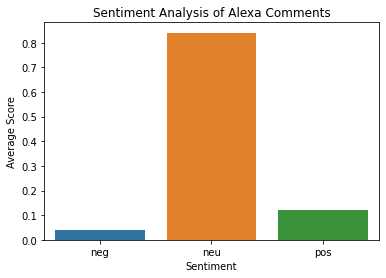

In [60]:
alexa_post_sent_com = sentiment_com[sentiment_com['subreddit'] == 'alexa'][['neg','neu','pos']].mean().reset_index()
alexa_post_sent_com.columns = ['Sentiment','Average Score']

sns.barplot(alexa_post_sent_com['Sentiment'],alexa_post_sent_com['Average Score'] )
plt.title('Sentiment Analysis of Alexa Comments');

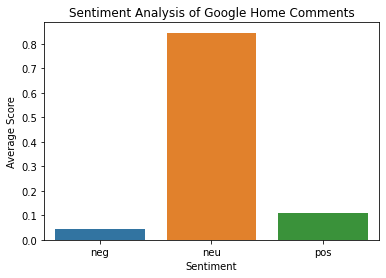

In [61]:
google_post_sent_com = sentiment_com[sentiment_com['subreddit'] == 'googlehome'][['neg','neu','pos']].mean().reset_index()
google_post_sent_com.columns = ['Sentiment','Average Score']

sns.barplot(google_post_sent_com['Sentiment'],google_post_sent_com['Average Score'] )
plt.title('Sentiment Analysis of Google Home Comments');

### Investigate Compound Score

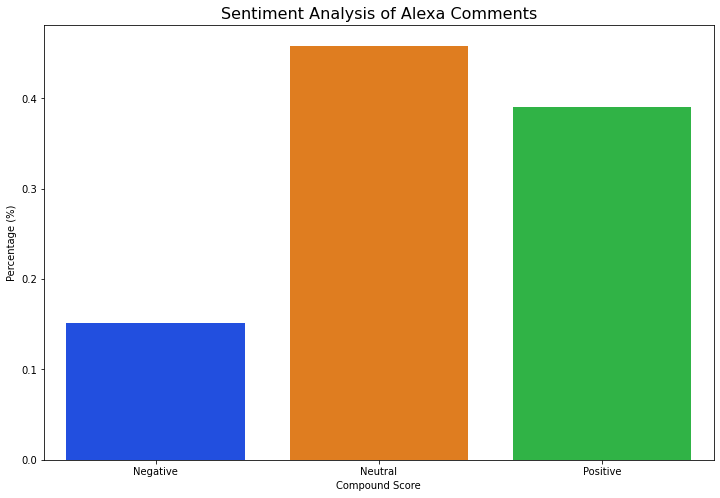

In [62]:
#calculate positve, negative, or neutral counts based on compound score
alexa_neg_com = sentiment_com[(sentiment_com['compound'] < -0.05) & (sentiment_com['subreddit'] == 'alexa')]['id'].count()
alexa_neu_com = sentiment_com[(sentiment_com['compound'] >= -0.05) & (sentiment_com['compound'] <= 0.05) &(sentiment_com['subreddit'] == 'alexa')]['id'].count()
alexa_pos_com = sentiment_com[(sentiment_com['compound'] > 0.05) &(sentiment_com['subreddit'] == 'alexa')]['id'].count()
alexa_total_com = sentiment_com[sentiment_com['subreddit'] == 'alexa']['id'].count()



plt.figure(figsize=(12,8))
sns.barplot(['Negative','Neutral','Positive'],[(alexa_neg_com / alexa_total_com),(alexa_neu_com / alexa_total_com),(alexa_pos_com / alexa_total_com)], palette='bright')
plt.title('Sentiment Analysis of Alexa Comments',fontsize=16);
plt.xlabel('Compound Score')
plt.ylabel('Percentage (%)')
plt.savefig('./imgs/alexa_sentiment_com_compound.jpeg',bbox_inches='tight');

In [63]:
print(f'Percent Negative: {alexa_neg_com / alexa_total_com}')
print(f'Percent Neutral: {alexa_neu_com / alexa_total_com}')
print(f'Percent Positive: {alexa_pos_com / alexa_total_com}')

Percent Negative: 0.1508745247148289
Percent Neutral: 0.45840304182509506
Percent Positive: 0.39072243346007607


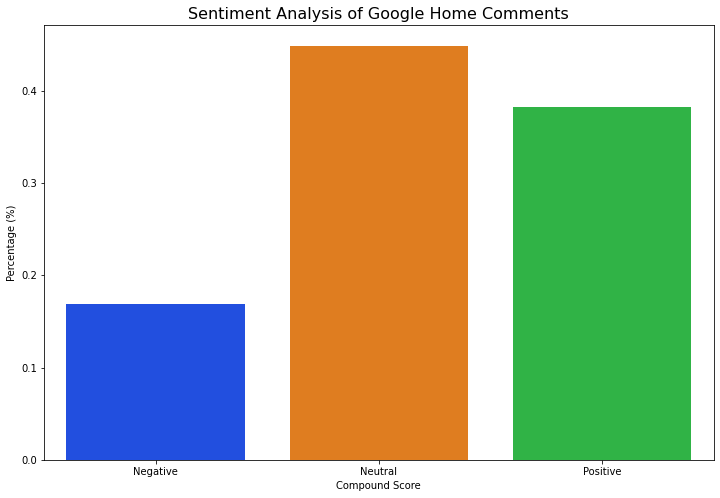

In [64]:
#calculate positve, negative, or neutral counts based on compound score
google_neg_com = sentiment_com[(sentiment_com['compound'] < -0.05) & (sentiment_com['subreddit'] == 'googlehome')]['id'].count()
google_neu_com = sentiment_com[(sentiment_com['compound'] >= -0.05) & (sentiment_com['compound'] <= 0.05) &(sentiment_com['subreddit'] == 'googlehome')]['id'].count()
google_pos_com = sentiment_com[(sentiment_com['compound'] > 0.05) &(sentiment_com['subreddit'] == 'googlehome')]['id'].count()
google_total_com = sentiment_com[sentiment_com['subreddit'] == 'googlehome']['id'].count()



plt.figure(figsize=(12,8))
sns.barplot(['Negative','Neutral','Positive'],[(google_neg_com / google_total_com),(google_neu_com / google_total_com),(google_pos_com / google_total_com)], palette='bright')
plt.title('Sentiment Analysis of Google Home Comments',fontsize=16);
plt.xlabel('Compound Score')
plt.ylabel('Percentage (%)')
plt.savefig('./imgs/google_sentiment_com_compound.jpeg',bbox_inches='tight');

In [65]:
print(f'Percent Negative: {google_neg_com / google_total_com}')
print(f'Percent Neutral: {google_neu_com / google_total_com}')
print(f'Percent Positive: {google_pos_com / google_total_com}')

Percent Negative: 0.1689376443418014
Percent Neutral: 0.448729792147806
Percent Positive: 0.38233256351039263


## Exploring Company Comparisons

Let's look at posts that both have the word `Alexa` and `Google`

In [66]:
sentiment[sentiment['text'].str.contains('alexa.*google|google.*alexa', regex=True)] #count of 7

#credit: https://stackoverflow.com/questions/4389644/regex-to-match-string-containing-two-names-in-any-order

,neg,neu,pos,compound,text,subreddit,id,comment_link_id,title,selftext,score,upvote_ratio,num_comments,flair,url,author,created,class
1005,0.000,1.000,0.000,0.0000,Can i use alexa for google meet?,alexa,if0jzg,t3_if0jzg,Can i use alexa for google meet?,,0,0.50,1,NaN,https://www.reddit.com/r/alexa/comments/if0jzg/can_i_use_alexa_for_google_meet/,Apathy220,2020-08-23 02:48:56,1
1089,0.065,0.878,0.057,0.0077,Eufy ecosystem Is anyone using the eufy cams (indoor/outdoor)/smart doorbell/smart lock/sensors? I'm kind of leaning towards these now since I dont like what I'm reading about the wyze products. I wanted to bite the bullet on the wyze stuff but reading to much and info overload. I wanna kind of keep them all in one ecosystem if possible. I'm the eufy sensors can be used like the wyze say to turn on the lights in the kitchen at night when someone walks in. If my nest hello would only send instant alerts to my phone along with the google hub.....aww well gonna try out alexa. Thanks for any input...,alexa,ial4qn,t3_ial4qn,Eufy ecosystem,Is anyone using the eufy cams (indoor/outdoor)/smart doorbell/smart lock/sensors? I'm kind of leaning towards these now since I dont like what I'm reading about the wyze products. I wanted to bite the bullet on the wyze stuff but reading to much and info overload. I wanna kind of keep them all in one ecosystem if possible. I'm the eufy sensors can be used like the wyze say to turn on the lights in the kitchen at night when someone walks in. If my nest hello would only send instant alerts to my phone along with the google hub.....aww well gonna try out alexa. Thanks for any input...,0,0.50,0,NaN,https://www.reddit.com/r/alexa/comments/ial4qn/eufy_ecosystem/,murrshot,2020-08-15 20:05:48,1
1406,0.000,0.945,0.055,0.4836,"Alexa regarding PC, Custom? Anyway? From google Ive saw Alexa cannot operate or open stuff on your pc i.e ""Alexa, Open (game name)"" Is there anyway to make this possible? Ive made my lights and such smart, I would like to see if I can use alexa to operate or launch things on my PC I would use 'connect' but I cant seem to find the download for it and dont know if it works for games.",alexa,hso36p,t3_hso36p,"Alexa regarding PC, Custom? Anyway?","From google Ive saw Alexa cannot operate or open stuff on your pc i.e ""Alexa, Open (game name)"" Is there anyway to make this possible? Ive made my lights and such smart, I would like to see if I can use alexa to operate or launch things on my PC I would use 'connect' but I cant seem to find the download for it and dont know if it works for games.",0,0.33,2,NaN,https://www.reddit.com/r/alexa/comments/hso36p/alexa_regarding_pc_custom_anyway/,Pumpedhero,2020-07-16 20:03:20,1
1429,0.175,0.674,0.151,-0.1179,"Does IP Isolation affect alexa devices? On a public internet and have been trying to setup a google home mini with no success and im pretty sure its to do with IP isolation, does alexa devices need ip isolation turned off to be able to connect it and use it?",alexa,hr7om1,t3_hr7om1,Does IP Isolation affect alexa devices?,"On a public internet and have been trying to setup a google home mini with no success and im pretty sure its to do with IP isolation, does alexa devices need ip isolation turned off to be able to connect it and use it?",1,0.57,1,NaN,https://www.reddit.com/r/alexa/comments/hr7om1/does_ip_isolation_affect_alexa_devices/,ZurvivorLDG,2020-07-14 12:05:55,1
1727,0.036,0.927,0.037,-0.4345,"Custom voice commands in routines Ok so i have a google home mini in my bedroom and i just got my alexa today and put it by my PC. been playing around with it and i can't find out how to replicate an action in my routine that is on my mini on the alexa ( would like to have the same routine on both so when im downstairs i can say the bedtime routine and my lights/tv will be on when i get upstairs). I have a roku tv and i have it set up on the mini so when i say ""ok google bedtime"" it will turn on my lamp+tv and after that i have a command in th

### Comments with both `alexa` and `google` in the text

In [67]:
sentiment_com[sentiment_com['comment_body'].str.contains('alexa.*google|google.*alexa', regex=True)] #count of 12

,neg,neu,pos,compound,comment_body,comment_id,comment_parent_id,comment_link_id,subreddit,id,title,selftext,score,upvote_ratio,num_comments,flair,url,author,created,class,text
267,0.054,0.770,0.176,0.8290,"first thing i recommend to friends about alexa, is don't use it for music, unless your happy with poor audio quality and lots of voice input to make it seem like it works... best is to set up spotify with much better quality speakers in your home, and use the spotify app across all devices. alexa however is still the best for its custom routines, smart home devices and some skills compared to google, but both imo are simply not good enough for music playback...",g2ef3ii,t3_ie5i24,t3_ie5i24,alexa,ie5i24,"Years later, Alexa is still piss poor. Why?","Here we are years later yet Prime Music with Alexa is still so bad that it makes paying for Music Unlimited a mistake. \n\nHere I am sitting in my house on wifi, playing music from Prime on my iPhone to my Lounge group of Dots. It will play for a couple minutes, break up, then die. \n\nWhen I ask Alexa to continue playing the same album I’m told that it’s only available via Music Unlimited. A moment ago I was playing this via my bog standard prime music. This is not uncommon. \n\nThen about a minute later it starts playing again. \n\nWho is actually relying on this shitshow to play music? It’s really weak ass. God. Is there a drive at Amazon to make us all buy vinyl again? Probably.",6,0.80,5,NaN,https://www.reddit.com/r/alexa/comments/ie5i24/years_later_alexa_is_still_piss_poor_why/,happyfeet2039,2020-08-21 14:15:29,1,"Years later, Alexa is still piss poor. Why? Here we are years later yet Prime Music with Alexa is still so bad that it makes paying for Music Unlimited a mistake. \n\nHere I am sitting in my house on wifi, playing music from Prime on my iPhone to my Lounge group of Dots. It will play for a couple minutes, break up, then die. \n\nWhen I ask Alexa to continue playing the same album I’m told that it’s only available via Music Unlimited. A moment ago I was playing this via my bog standard prime music. This is not uncommon. \n\nThen about a minute later it starts playing again. \n\nWho is actually relying on this shitshow to play music? It’s really weak ass. God. Is there a drive at Amazon to make us all buy vinyl again? Probably."
568,0.075,0.868,0.057,-0.2247,"That's so bad photoshop, just look at the bezels.\n\nJust get a cheap tablet you can get alexa and google assistant on it, use widgets, automate it with tasker and pincode? Has bluetooth you can build it on a stand or make your own stand with better speaker.",g1leirc,t3_i9ulz8,t3_i9ulz8,alexa,i9ulz8,On my echo show is there anyway to permanently show my google calendar?,,26,0.84,24,NaN,https://i.redd.it/m12di373c1h51.jpg,GenericUser104,2020-08-14 14:21:52,1,On my echo show is there anyway to permanently show my google calendar?
731,0.035,0.751,0.214,0.8313,Yeah it’s confusing because the tv supports BEING the alexa/google device and also being CONTROLLED BY the Alexa/google device. Glad it’s working for you now. Next step is getting used to the terminology you have to use to have Alexa play what you want on the TV!,g1msaxv,t1_g1mrr8f,t3_i8kce5,alexa,i8kce5,LG TV issues,"I'm trying to setup my new TV (LG 75SM8670AUA [https://www.lg.com/us/tvs/lg-75SM8670AUA-4k-uhd-tv](https://www.lg.com/us/tvs/lg-75SM8670AUA-4k-uhd-tv) with WebOS 4.6) to connect to my Alexa devices, I have 3 echo dot's through the house.\n\nI am able to launch the Alexa app on the TV and log in just fine. I've also created and logged into LG ThinQ app and can control the TV when it is powered on through the app.\n\nHowever, I am unable to control the TV through Alexa despite the advertising of this TV as Alexa compatible and not sure what the problem is.\n\nAfter logging into Alexa through the app on TV, the TV is added to my account and is shown in my list of devices as 'XXXX's webOS TV' (per attached picture) in the Alexa app on my iPhone. Howe